# Process CAS04 with Remote Reference


This notebook is a companion to the 2024 JOSS manuscript.

This notebook is shows the workflow for getting data from Earthscope for a few example stations and generating transfer functions using aurora.  The data download step is based on condensed version of a tutorial in the mth5 documentation which can be found at: https://github.com/kujaku11/mth5/tree/master/docs/examples/notebooks.  



In [1]:
# %matplotlib notebook 
# %matplotlib widget


In [2]:
#Imports

import pandas as pd
import pathlib
import os
#from aurora.sandbox.mth5_channel_summary_helpers import channel_summary_to_make_mth5
#from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import FDSN
from mth5.utils.helpers import initialize_mth5
from mth5.processing import RunSummary, KernelDataset


In [3]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

# Make MTH5 from IRIS Data Managment Center v0.2.0 

This example demonstrates how to build an MTH5 from data archived at IRIS, it could work with any MT data stored at an FDSN data center (probably).

We will use the `mth5.clients.FDSN` class to build the file.  There is also second way using the more generic `mth5.clients.MakeMTH5` class, which will be highlighted below. 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [4]:
fdsn_object = FDSN(mth5_version='0.2.0')
fdsn_object.client = "IRIS"

## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

In the example below, the stage is set to use two stations: CAS04 and NVR08.  Commented out is an example of how to add a third station, REV06

In [5]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
CAS04 = ["8P", "CAS04",  '2020-06-02T19:00:00', '2020-07-13T19:00:00'] 
NVR08 = ["8P", "NVR08", '2020-06-02T19:00:00', '2020-07-13T19:00:00']
# REV06 = ["8P", "REV06", '2020-06-02T19:00:00', '2020-07-13T19:00:00']

stations = [CAS04, NVR08,]
# stations.append(REV06)

request_list = []
for entry in stations:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_object.request_columns) 
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,NVR08,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,NVR08,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,NVR08,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,NVR08,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,NVR08,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00


In [6]:
%%time

mth5_filename = fdsn_object.make_mth5_from_fdsn_client(request_df)

print(f"Created {mth5_filename}")

2025-11-17T18:53:12.720888+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.724213+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.


2025-11-17T18:53:12.740524+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.743269+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.


2025-11-17T18:53:12.757313+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.760204+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.


2025-11-17T18:53:12.774512+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.777465+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.


2025-11-17T18:53:12.796771+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.799363+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.


2025-11-17T18:53:12.856598+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.859574+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_94.000 to a CoefficientFilter.


2025-11-17T18:53:12.878290+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.


2025-11-17T18:53:12.881119+0000 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_94.000 to a CoefficientFilter.


2025-11-17T18:53:12.902384+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterSurvey, skipping from_dict.


2025-11-17T18:53:12.903145+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Reports, skipping from_dict.


2025-11-17T18:53:13.162064+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Standards, skipping from_dict.


2025-11-17T18:53:13.167415+0000 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /home/runner/work/aurora/aurora/docs/tutorials/8P_CAS04_NVR08.h5 in mode w


2025-11-17T18:53:13.171156+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterStation, skipping from_dict.


2025-11-17T18:53:13.172060+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Reports, skipping from_dict.


2025-11-17T18:53:13.173600+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Filters, skipping from_dict.


2025-11-17T18:53:13.440954+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Standards, skipping from_dict.


2025-11-17T18:53:13.453083+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Station, skipping from_dict.


2025-11-17T18:53:13.458153+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for TransferFunctions, skipping from_dict.


2025-11-17T18:53:13.459189+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFC, skipping from_dict.


2025-11-17T18:53:13.460224+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFeatures, skipping from_dict.


2025-11-17T18:53:13.464353+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:13.502153+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:13.539235+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:13.576368+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:14.070504+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Station, skipping from_dict.


2025-11-17T18:53:14.075636+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for TransferFunctions, skipping from_dict.


2025-11-17T18:53:14.076705+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFC, skipping from_dict.


2025-11-17T18:53:14.077665+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for MasterFeatures, skipping from_dict.


2025-11-17T18:53:14.081759+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:14.118273+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:14.154955+0000 | WARNING | mth5.groups.base | read_metadata | No metadata found for Run, skipping from_dict.


2025-11-17T18:53:14.937124+0000 | WARNING | mth5.clients.fdsn | wrangle_runs_into_containers | More or less runs have been requested by the user than are defined in the metadata. Runs will be defined but only the requested run extents contain time series data based on the users request.


2025-11-17T18:53:14.942249+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:14.948374+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:15.060811+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00


2025-11-17T18:53:15.179147+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:15.321177+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:15.462534+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:15.604660+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:15.748169+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:15.800654+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:15.806286+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:15.831200+0000 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.


2025-11-17T18:53:16.141077+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:16.285754+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:16.429381+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:16.573866+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:16.720181+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:16.779413+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:16.785165+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:16.809828+0000 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.


2025-11-17T18:53:16.834827+0000 | INFO | mth5.groups.base | _add_group | RunGroup c already exists, returning existing group.


2025-11-17T18:53:17.233188+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:17.379397+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:17.526364+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:17.672759+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:17.821568+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:17.884541+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:17.891236+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:17.916757+0000 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.


2025-11-17T18:53:17.942005+0000 | INFO | mth5.groups.base | _add_group | RunGroup c already exists, returning existing group.


2025-11-17T18:53:17.967452+0000 | INFO | mth5.groups.base | _add_group | RunGroup d already exists, returning existing group.


2025-11-17T18:53:18.158051+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-07-13T19:00:00+00:00 does not match metadata end 2020-07-13T21:46:12+00:00 updating metatdata value to 2020-07-13T19:00:00+00:00


2025-11-17T18:53:18.297609+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id d. Setting to ch.run_metadata.id to d


2025-11-17T18:53:18.443144+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id d. Setting to ch.run_metadata.id to d


2025-11-17T18:53:18.586496+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id d. Setting to ch.run_metadata.id to d


2025-11-17T18:53:18.730848+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id d. Setting to ch.run_metadata.id to d


2025-11-17T18:53:18.877657+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id d. Setting to ch.run_metadata.id to d


2025-11-17T18:53:18.938573+0000 | WARNING | mth5.clients.fdsn | wrangle_runs_into_containers | More or less runs have been requested by the user than are defined in the metadata. Runs will be defined but only the requested run extents contain time series data based on the users request.


2025-11-17T18:53:18.942916+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:18.948007+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:19.174117+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:19.315939+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:19.457565+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:19.599507+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:19.743633+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id a. Setting to ch.run_metadata.id to a


2025-11-17T18:53:19.795259+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:19.800596+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:19.825102+0000 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.


2025-11-17T18:53:20.142264+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:20.289665+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:20.432848+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:20.577351+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:20.724026+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id b. Setting to ch.run_metadata.id to b


2025-11-17T18:53:20.782756+0000 | INFO | mth5.groups.base | _add_group | RunGroup Features already exists, returning existing group.


2025-11-17T18:53:20.787899+0000 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.


2025-11-17T18:53:20.812252+0000 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.


2025-11-17T18:53:20.836704+0000 | INFO | mth5.groups.base | _add_group | RunGroup c already exists, returning existing group.


2025-11-17T18:53:21.146693+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:21.292215+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:21.436370+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:21.581599+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:21.728483+0000 | WARNING | mth5.groups.run | from_runts | Channel run.id sr1_001 !=  group run.id c. Setting to ch.run_metadata.id to c


2025-11-17T18:53:21.945632+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/runner/work/aurora/aurora/docs/tutorials/8P_CAS04_NVR08.h5


Created /home/runner/work/aurora/aurora/docs/tutorials/8P_CAS04_NVR08.h5
CPU times: user 9.57 s, sys: 358 ms, total: 9.93 s
Wall time: 2min 7s


In [7]:
mth5_path = pathlib.Path("8P_CAS04_NVR08.h5")

In [8]:
m = initialize_mth5(mth5_path)
m.channel_summary.summarize()
df = m.channel_summary.to_dataframe()
df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,335.261765,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,335.261765,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Fix Survey Name

- The survey name is extracted from the metadata provided by Earthscope
- The value of the survey name was changed from "CONUS South" to "CONUS SoCal", and the notebook was updated to reflect this, however, as of June 30, 2024, the name seems to have changed back to "CONUS South".
- To avoid problems wiht these change of nomencalature we extract the survey name as a variable

In [9]:
survey_id = df["survey"].unique()[0]
survey_id

'CONUS South'

In [10]:
df.station.unique()

array(['CAS04', 'NVR08'], dtype=object)

In [11]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2025-11-17T18:53:22.322571+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",11266.0,2020-06-02 22:07:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,11267,"[ex, ey, hz]",a,1.0,2020-06-02 19:00:00+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",847648.0,2020-06-12 17:52:23+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,847649,"[ex, ey, hz]",b,1.0,2020-06-02 22:24:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1638042.0,2020-07-01 17:32:59+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1638043,"[ex, ey, hz]",c,1.0,2020-06-12 18:32:17+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1034585.0,2020-07-13 19:00:00+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1034586,"[ex, ey, hz]",d,1.0,2020-07-01 19:36:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
4,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2860.0,2020-06-03 19:57:51+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,2861,"[ex, ey, hz]",a,1.0,2020-06-03 19:10:11+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
5,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",938509.0,2020-06-14 16:56:02+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,938510,"[ex, ey, hz]",b,1.0,2020-06-03 20:14:13+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
6,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",856502.0,2020-06-24 15:55:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,856503,"[ex, ey, hz]",c,1.0,2020-06-14 18:00:44+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>


In [12]:
coverage_short_list_columns = ["survey", 'station', 'run', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

,survey,station,run,start,end
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00
4,CONUS South,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00
5,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00
6,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [13]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = "NVR08"
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

2025-11-17T18:53:22.353911+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.


2025-11-17T18:53:22.354832+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.


2025-11-17T18:53:22.355551+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:22.356964+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:22.357500+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,CONUS South,CAS04,b,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
1,CONUS South,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
2,CONUS South,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
3,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
4,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
5,CONUS South,NVR08,b,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
6,CONUS South,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0
7,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0


In [14]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
cutoff_duration_in_seconds = 180000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

2025-11-17T18:53:22.376368+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.


2025-11-17T18:53:22.377234+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.


2025-11-17T18:53:22.378040+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:22.379237+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:22.379824+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end
0,CONUS South,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
1,CONUS South,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
2,CONUS South,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00
3,CONUS South,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [15]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
#                                       emtf_band_file=BANDS_DEFAULT_FILE,)

2025-11-17T18:53:22.403544+0000 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [16]:
config

{
    "processing": {
        "band_setup_file": "/home/runner/work/aurora/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
                            }
                        },
  

In [17]:
for dec_level in config.decimations:
    dec_level.stft.window.type = "hamming"

In [18]:
tf_file_base = f"{station_id}_RR{remote_reference_id}"

2025-11-17T18:53:22.467037+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:


2025-11-17T18:53:22.474359+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
    duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   769090.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128     769090.0            8011.0
1   769090.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128     192272.0            2002.0
2   769090.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         2         4.0     0

2025-11-17T18:53:22.475609+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total memory: 15.62 GB


2025-11-17T18:53:22.476304+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total Bytes of Raw Data: 0.024 GB


2025-11-17T18:53:22.476861+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Raw Data will use: 0.155 % of memory


2025-11-17T18:53:22.486926+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: b-- Fourier coefficients will be computed


2025-11-17T18:53:22.646800+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:22.656279+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: c-- Fourier coefficients will be computed


2025-11-17T18:53:22.815673+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:22.824557+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: NVR08, run: b-- Fourier coefficients will be computed


2025-11-17T18:53:22.983876+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:22.993011+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: NVR08, run: c-- Fourier coefficients will be computed


2025-11-17T18:53:23.151903+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:23.153793+0000 | INFO | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | FC levels not present


2025-11-17T18:53:23.157572+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | Processing config indicates 4 decimation levels


2025-11-17T18:53:23.158972+0000 | INFO | aurora.pipelines.transfer_function_kernel | valid_decimations | After validation there are 4 valid decimation levels


2025-11-17T18:53:23.527880+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-03T20:14:13+00:00 does not match metadata start 2020-06-02T22:24:55+00:00 updating metatdata value to 2020-06-03T20:14:13+00:00


2025-11-17T18:53:23.910320+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-12T17:52:23+00:00 does not match metadata end 2020-06-14T16:56:02+00:00 updating metatdata value to 2020-06-12T17:52:23+00:00


2025-11-17T18:53:24.308131+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-14T18:00:44+00:00 does not match metadata start 2020-06-12T18:32:17+00:00 updating metatdata value to 2020-06-14T18:00:44+00:00


2025-11-17T18:53:24.309570+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-24T15:55:46+00:00 does not match metadata end 2020-07-01T17:32:59+00:00 updating metatdata value to 2020-06-24T15:55:46+00:00


2025-11-17T18:53:24.728888+0000 | INFO | mth5.processing.kernel_dataset | initialize_dataframe_for_processing | Dataset dataframe initialized successfully


2025-11-17T18:53:24.731115+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 0 Successfully


2025-11-17T18:53:25.352489+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:25.891981+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:26.479776+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:27.079948+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:27.106435+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:53:27.114997+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:27.238713+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:27.432342+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:27.627578+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:27.907863+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:28.152493+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:28.461339+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:28.782346+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:53:29.175120+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:29.321171+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:29.516811+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:29.712830+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:29.996355+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:30.243724+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:30.551421+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:30.871453+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:53:31.260855+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:31.404208+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:31.600232+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:31.796106+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:32.077409+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:32.320969+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:32.626559+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:32.943606+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


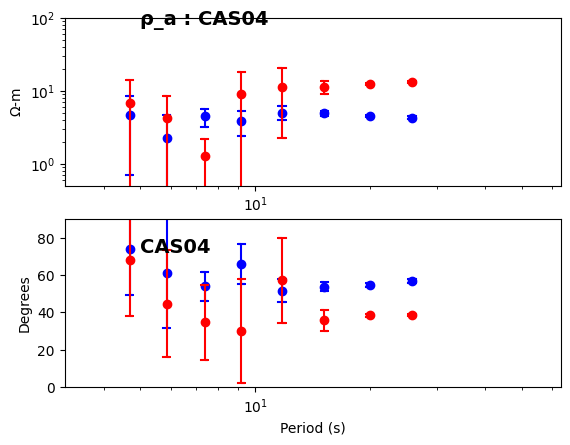

2025-11-17T18:53:33.989697+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1


2025-11-17T18:53:34.286084+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully


2025-11-17T18:53:34.559222+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:34.867217+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:35.144367+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:35.457859+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:35.469683+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:53:35.476395+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:53:35.536627+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:53:35.609840+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:53:35.706515+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:53:35.803065+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:53:35.908777+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:53:36.026375+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:53:36.103426+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:53:36.176580+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:53:36.272714+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:53:36.369230+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:53:36.475545+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:53:36.593062+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:53:36.670080+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:53:36.743072+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:53:36.839176+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:53:36.935491+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:53:37.041774+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


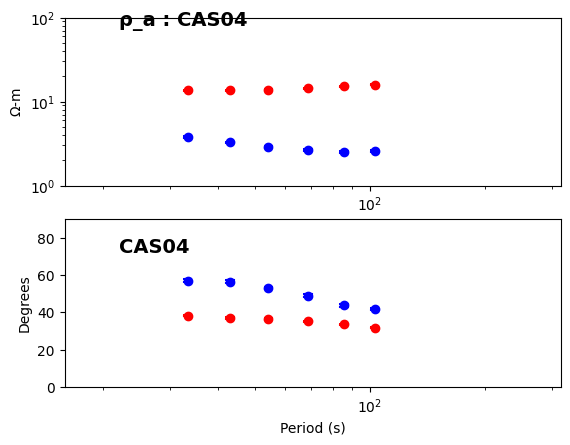

2025-11-17T18:53:37.637322+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2


2025-11-17T18:53:37.742087+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully


2025-11-17T18:53:37.960365+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:38.202982+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:38.419870+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:38.664281+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:38.672472+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:53:38.679105+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:53:38.722692+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:53:38.765332+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:53:38.812735+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:53:38.871280+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:53:38.937563+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:53:39.010826+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:53:39.066537+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:53:39.119444+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:53:39.166950+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:53:39.225552+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:53:39.290945+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:53:39.364076+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:53:39.420556+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:53:39.473799+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:53:39.521035+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:53:39.579610+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:53:39.644994+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


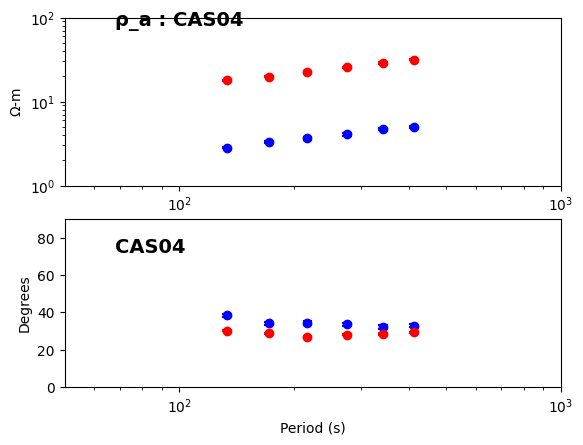

2025-11-17T18:53:40.212480+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3


2025-11-17T18:53:40.269160+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully


2025-11-17T18:53:40.473010+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:40.704692+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:40.906791+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:41.137404+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:53:41.145037+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:53:41.151016+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:53:41.192464+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:53:41.234118+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:53:41.276207+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:53:41.317990+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:53:41.362946+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:53:41.403874+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:53:41.446600+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:53:41.489237+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:53:41.531811+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:53:41.575514+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:53:41.616023+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:53:41.657480+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:53:41.699269+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:53:41.741081+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


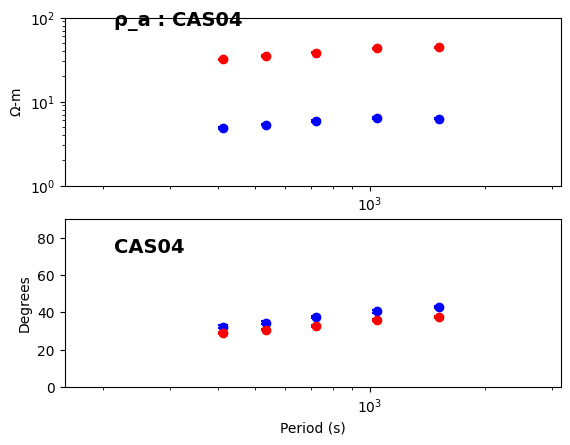

2025-11-17T18:53:42.386005+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>


2025-11-17T18:53:42.468470+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | Transfer function object written to CAS04_RRNVR08.zrr


2025-11-17T18:53:42.628543+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:42.787349+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


In [19]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [20]:
tf_cls.write(fn=f"{tf_file_base}.xml", file_type="emtfxml")
tf_cls.write(fn=f"{tf_file_base}.edi", file_type="edi")
tf_cls.write(fn=f"{tf_file_base}.zrr", file_type="zrr")

MT( station='0', latitude=0.00, longitude=0.00, elevation=0.00 )

In [21]:
archived_z_file = pathlib.Path(f"CAS04bcd_REV06.zrr")

In [22]:
from aurora.transfer_function.plot.comparison_plots import compare_two_z_files
z_file_path = "CAS04_RRNVR08.zrr"

#  To compare with the archived file, we need to set the coordinate system to geographic

The TF will be output with a header like this:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1    13.20     0.00 CAS04  Hx
    2   103.20     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4    13.20     0.00 CAS04  Ex
    5   103.20     0.00 CAS04  Ey
```

To remove the rotation, we can use a variety of tools, but another way is just to overwrite the orientations:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
 Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1     0.00     0.00 CAS04  Hx
    2    90.00     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4     0.00     0.00 CAS04  Ex
    5    90.00     0.00 CAS04  Ey
```

This is why we set angle1=13.2 degrees in the comparison plotter.

In [23]:
print(z_file_path)
print(archived_z_file)
print(tf_file_base)

CAS04_RRNVR08.zrr
CAS04bcd_REV06.zrr
CAS04_RRNVR08


2025-11-17T18:53:42.987167+0000 | INFO | aurora.transfer_function.plot.comparison_plots | compare_two_z_files | Scaling TF scale_factor1: 1


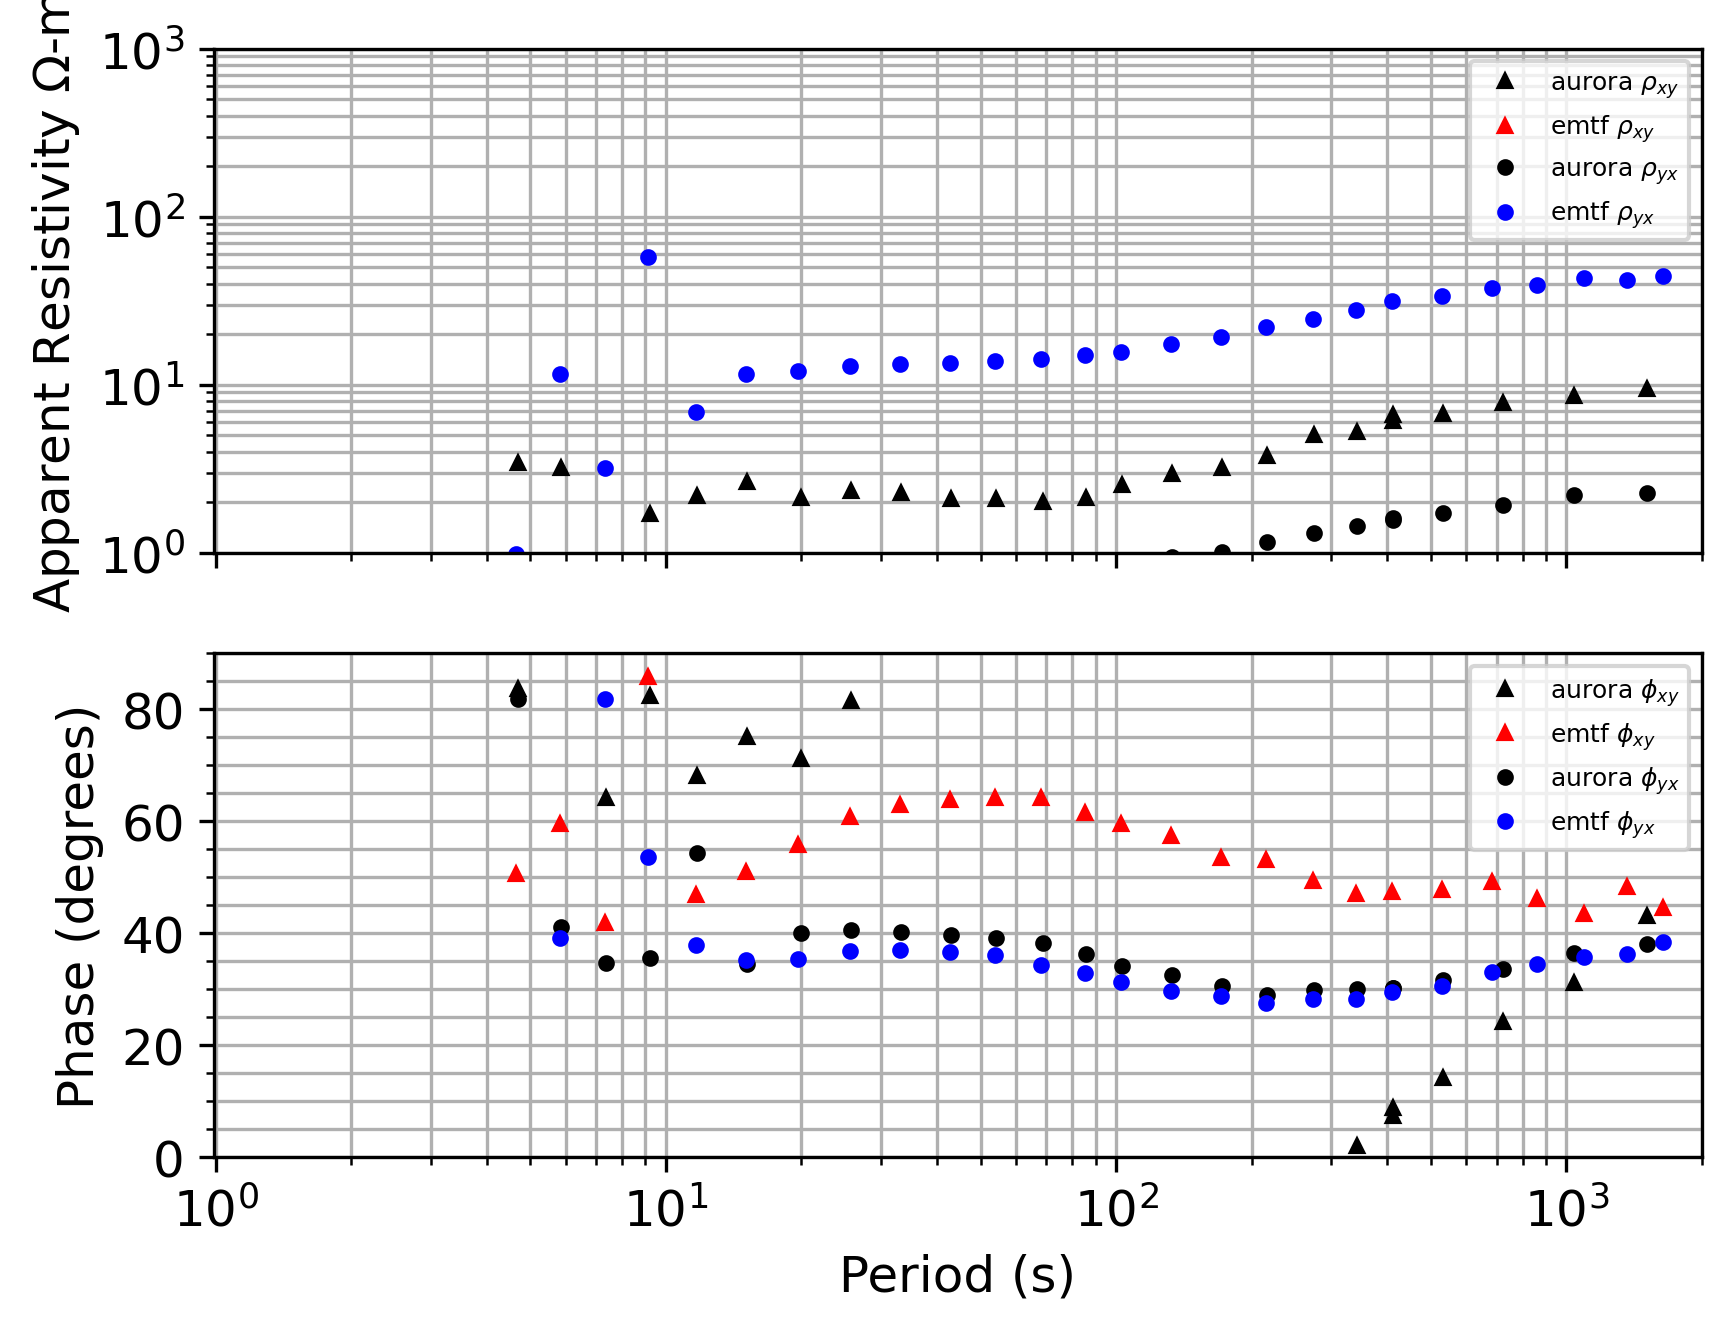

In [24]:
compare_two_z_files(
    z_file_path,
    archived_z_file,
    angle1=+13.2,
    label1="aurora",
    label2="emtf",
    scale_factor1=1,
    out_file=f"{tf_file_base}compare.png",
    markersize=3,
    rho_ylims=[1e0, 1e3],
    xlims=[0.99, 2000],
    rho_ax_label_size=12,
    phi_ax_label_size=12
)

# Part II: Logic to save FCs

Storage of FCs was intended to be an option to provide to users on the fly, by setting the decimation_level
part of the processing config to `dec_level.save_fcs = True` and `dec_level.save_fcs_type = "h5"`.

This works in some cases but not in general.  Details are in aurora issue #319 https://github.com/simpeg/aurora/issues/319.  

The proposed solution is to generate FCs per station by processing as a single station.

We start with the Run Summary table:

In [25]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2025-11-17T18:53:44.312060+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",11266.0,2020-06-02 22:07:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,11267,"[ex, ey, hz]",a,1.0,2020-06-02 19:00:00+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",847648.0,2020-06-12 17:52:23+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,847649,"[ex, ey, hz]",b,1.0,2020-06-02 22:24:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1638042.0,2020-07-01 17:32:59+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1638043,"[ex, ey, hz]",c,1.0,2020-06-12 18:32:17+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1034585.0,2020-07-13 19:00:00+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,1034586,"[ex, ey, hz]",d,1.0,2020-07-01 19:36:55+00:00,CAS04,CONUS South,<HDF5 object reference>,<HDF5 object reference>
4,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2860.0,2020-06-03 19:57:51+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,2861,"[ex, ey, hz]",a,1.0,2020-06-03 19:10:11+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
5,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",938509.0,2020-06-14 16:56:02+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,938510,"[ex, ey, hz]",b,1.0,2020-06-03 20:14:13+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>
6,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",856502.0,2020-06-24 15:55:46+00:00,True,"[hx, hy]",8P_CAS04_NVR08.h5,856503,"[ex, ey, hz]",c,1.0,2020-06-14 18:00:44+00:00,NVR08,CONUS South,<HDF5 object reference>,<HDF5 object reference>


### But this time, process stations individually (e.g. CAS04 as below)

In [26]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = None
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

2025-11-17T18:53:44.334479+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.


2025-11-17T18:53:44.335409+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.


2025-11-17T18:53:44.336370+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:44.337069+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:53:44.337922+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,CONUS South,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11266.0
1,CONUS South,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847648.0
2,CONUS South,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1638042.0
3,CONUS South,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1034585.0


Before adding the FCs, take a look at the file stats:

In [27]:
file_info = os.stat(mth5_path)
print(f"file_info: \n {file_info}")

file_size_before_fc_addition = file_info.st_size
print(f"file_size_before_fc_addition {file_size_before_fc_addition}")

file_info: 
 os.stat_result(st_mode=33188, st_ino=353673, st_dev=2065, st_nlink=1, st_uid=1001, st_gid=1001, st_size=107290636, st_atime=1763405624, st_mtime=1763405624, st_ctime=1763405624)
file_size_before_fc_addition 107290636


In [28]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
for dec_level in config.decimations:
    dec_level.stft.window.type = "hamming"
#    dec_level.stft.window.overlap = int(dec_level.stft.window.num_samples/4)
    dec_level.save_fcs = True
    dec_level.save_fcs_type = "h5"

2025-11-17T18:53:44.360433+0000 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [29]:
config

{
    "processing": {
        "band_setup_file": "/home/runner/work/aurora/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
                            }
                        },
  

In [30]:
tf_file_base = f"{station_id}_SS"

2025-11-17T18:53:44.415974+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:


2025-11-17T18:53:44.422363+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
     duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0     11266.0      True      11267   a   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128      11266.0             117.0
1     11266.0      True      11267   a   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128       2816.0              29.0
2     11266.0      True      11267   a   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         2         4.0  

2025-11-17T18:53:44.422975+0000 | INFO | aurora.pipelines.transfer_function_kernel | validate_processing | No RR station specified, switching RME_RR to RME


2025-11-17T18:53:44.423373+0000 | INFO | aurora.pipelines.transfer_function_kernel | validate_processing | No RR station specified, switching RME_RR to RME


2025-11-17T18:53:44.423855+0000 | INFO | aurora.pipelines.transfer_function_kernel | validate_processing | No RR station specified, switching RME_RR to RME


2025-11-17T18:53:44.424279+0000 | INFO | aurora.pipelines.transfer_function_kernel | validate_processing | No RR station specified, switching RME_RR to RME


2025-11-17T18:53:44.425984+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total memory: 15.62 GB


2025-11-17T18:53:44.426831+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total Bytes of Raw Data: 0.026 GB


2025-11-17T18:53:44.427182+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Raw Data will use: 0.168 % of memory


2025-11-17T18:53:44.437396+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: a-- Fourier coefficients will be computed


2025-11-17T18:53:44.597987+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:44.607522+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: b-- Fourier coefficients will be computed


2025-11-17T18:53:44.767817+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:44.777284+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: c-- Fourier coefficients will be computed


2025-11-17T18:53:44.936727+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:44.946281+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: CAS04, run: d-- Fourier coefficients will be computed


2025-11-17T18:53:45.106075+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:53:45.107876+0000 | INFO | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | FC levels not present


2025-11-17T18:53:45.110586+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | Processing config indicates 4 decimation levels


2025-11-17T18:53:45.111732+0000 | INFO | aurora.pipelines.transfer_function_kernel | valid_decimations | After validation there are 4 valid decimation levels


2025-11-17T18:53:46.669870+0000 | INFO | mth5.processing.kernel_dataset | initialize_dataframe_for_processing | Dataset dataframe initialized successfully


2025-11-17T18:53:46.670736+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 0 Successfully


2025-11-17T18:53:46.872929+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:53:47.690737+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:53:49.008272+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:53:49.731203+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:53:49.870348+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:53:49.878714+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:50.030841+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:50.357476+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:50.639105+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:51.069546+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:51.504632+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:52.087846+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:52.653946+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:53:53.330230+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:53.501401+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:53.819568+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:54.099039+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:54.528087+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:54.959139+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:55.547614+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:56.120376+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:53:56.765189+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:53:56.936871+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:53:57.254997+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:53:57.534233+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:53:57.963960+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:53:58.395931+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:53:58.974546+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:53:59.633953+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


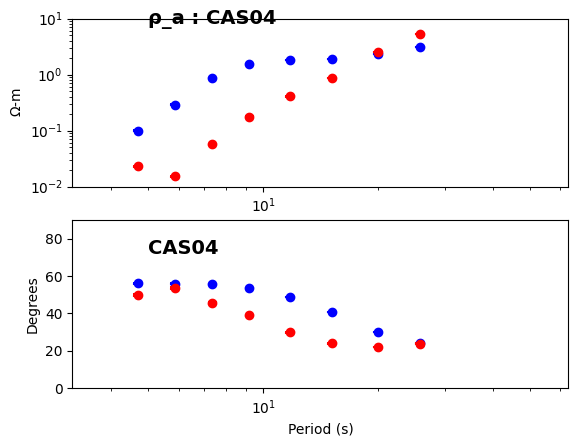

2025-11-17T18:54:00.987960+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1


2025-11-17T18:54:01.311230+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully


2025-11-17T18:54:01.486125+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:01.912543+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:02.360625+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:02.737990+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:02.823253+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:02.829870+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:02.886531+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:02.962594+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:03.077786+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:03.184944+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:03.334178+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:54:03.493089+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:03.568821+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:03.644464+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:03.758816+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:03.865321+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:04.011652+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:54:04.167561+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:04.245084+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:04.321618+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:04.440331+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:04.547277+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:04.694858+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


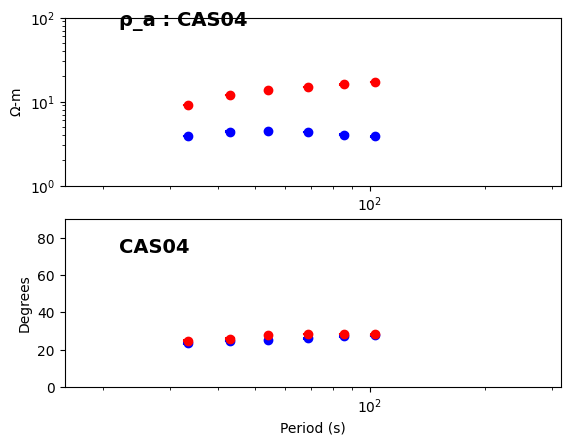

2025-11-17T18:54:05.349825+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2


2025-11-17T18:54:05.460838+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully


2025-11-17T18:54:05.634428+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:05.912845+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:06.216902+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:06.505325+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:06.576929+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:06.583536+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:06.618451+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:06.661142+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:06.714598+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:06.767260+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:06.833622+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:54:06.911391+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:06.952914+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:06.994535+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:07.047670+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:07.099150+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:07.165065+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:54:07.242226+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:07.284011+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:07.325548+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:07.378799+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:07.429966+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:07.495660+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


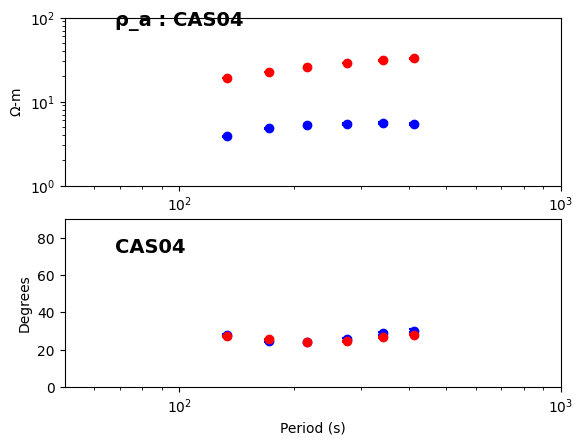

2025-11-17T18:54:08.086442+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3


2025-11-17T18:54:08.135261+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully


2025-11-17T18:54:08.342352+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:08.614382+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:08.886841+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Saving FC level


2025-11-17T18:54:08.954151+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:08.960501+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:08.990049+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:09.021733+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:09.055893+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:09.099451+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:54:09.146006+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:09.183441+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:09.223577+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:09.262855+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:09.304921+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:54:09.351542+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:09.389379+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:09.429631+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:09.468682+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:09.510774+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


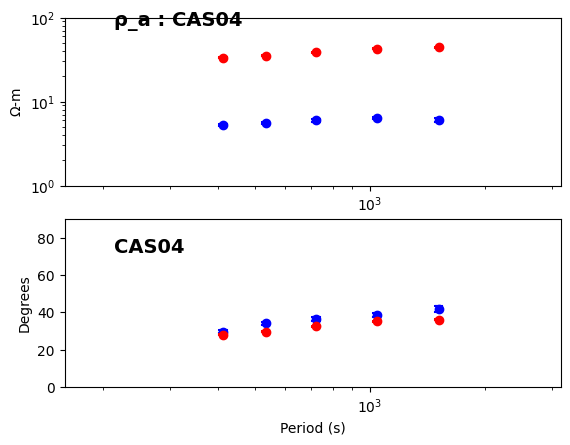

2025-11-17T18:54:10.108722+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>


2025-11-17T18:54:10.191001+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | Transfer function object written to CAS04_SS.zrr


2025-11-17T18:54:10.372898+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


In [31]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [32]:
file_info = os.stat(mth5_path)
print(f"file_info: \n {file_info}")

file_size_after_fc_addition = file_info.st_size
print(f"file_size_before_fc_addition {file_size_before_fc_addition}")
print(f"file_size_after_fc_addition {file_size_after_fc_addition}")

file_info: 
 os.stat_result(st_mode=33188, st_ino=353673, st_dev=2065, st_nlink=1, st_uid=1001, st_gid=1001, st_size=358561652, st_atime=1763405650, st_mtime=1763405650, st_ctime=1763405650)
file_size_before_fc_addition 107290636
file_size_after_fc_addition 358561652


# Now that the FCs are saved we can access them:|
- These plats are intended to be put in spectrogram class

In [33]:
# Choose what specific FCs we want:
# survey_id = "CONUS SoCal"  # declared directly from dataframe to avoid spurious name changes in archived metadata
station_id = "CAS04"
run_id = "b"
decimation_level_id = "0"

In [34]:
m = initialize_mth5(mth5_path)

In [35]:
survey_group = m.get_survey(survey_id)

In [36]:
station_obj = survey_group.stations_group.get_station(station_id)

In [37]:
fc_group = station_obj.fourier_coefficients_group.get_fc_group(run_id)
fc_decimation_level = fc_group.get_decimation_level(decimation_level_id)
stft_obj = fc_decimation_level.to_xarray()

In [38]:
stft_obj

<xarray.Dataset>
Dimensions:    (time: 8829, frequency: 64)
Coordinates:
  * time       (time) datetime64[ns] 2020-06-02T22:24:55 ... 2020-06-12T17:49:43
  * frequency  (frequency) float64 0.0 0.007812 0.01562 ... 0.4766 0.4844 0.4922
Data variables:
    ex         (time, frequency) complex128 (nan+nanj) ... (6.439846518048696...
    ey         (time, frequency) complex128 (nan+nanj) ... (1.142053688276462...
    hx         (time, frequency) complex128 0j ... (-7.255455721291725e-13+2....
    hy         (time, frequency) complex128 0j ... (-2.641145642245559e-13-1....
    hz         (time, frequency) complex128 0j ... (2.871147674970531e-14+1.2...

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
ex = stft_obj.ex
ex = ex.dropna(dim="frequency")
ex

<xarray.DataArray 'ex' (time: 8829, frequency: 63)>
array([[-2.78081633e-10-1.02555611e-09j,  2.31781444e-10+1.03764950e-09j,
        -1.41550822e-10-5.30183803e-10j, ...,
        -2.33846288e-13+3.78092145e-13j, -2.47517622e-13+2.97032949e-13j,
        -1.74394227e-13+5.33374852e-14j],
       [-8.61482145e-10+8.01328799e-10j,  7.58095286e-10-6.14537638e-10j,
        -4.36876512e-10+4.48085068e-10j, ...,
        -1.02114148e-13+1.87080731e-13j, -1.65973397e-13+1.33987254e-13j,
        -5.96086160e-14+4.73218577e-14j],
       [-6.04310100e-10+2.78710599e-10j,  2.87240419e-10-4.11793024e-10j,
         1.95180812e-10+5.92839940e-10j, ...,
        -7.23711253e-13+1.98678662e-13j, -2.22044210e-14-3.39406903e-14j,
         7.41191439e-14+2.94245970e-13j],
       ...,
       [-4.13217703e-11+1.09955015e-10j, -6.43407588e-11+3.08625349e-10j,
         7.63238077e-11-1.46336863e-10j, ...,
         1.15193186e-14-1.81437181e-13j, -1.21823774e-13+1.25575543e-13j,
         2.68503600e-14+6.82965584e-15j],
       [-4.32857850e-10-3.61859337e-10j,  4.70934913e-10-1.20136627e-10j,
        -1.31343395e-11+1.25999723e-10j, ...,
        -3.00292308e-13-2.17749579e-13j,  1.64397728e-13-4.27592123e-14j,
        -2.80084815e-14+1.08537469e-13j],
       [ 8.24399932e-11-4.68078003e-10j, -1.81195763e-10-8.34900678e-11j,
         1.11277791e-10-5.20690939e-11j, ...,
         2.01639036e-13+5.84642545e-14j, -1.51389614e-13+4.86360942e-14j,
         6.43984652e-14-3.82770840e-14j]])
Coordinates:
  * time       (time) datetime64[ns] 2020-06-02T22:24:55 ... 2020-06-12T17:49:43
  * frequency  (frequency) float64 0.007812 0.01562 0.02344 ... 0.4844 0.4922
Attributes:
    component:                     ex
    frequency_max:                 0.4921875
    frequency_min:                 0.0
    hdf5_reference:                <HDF5 object reference>
    mth5_type:                     FCChannel
    sample_rate_decimation_level:  1.0
    sample_rate_window_step:       96.0
    time_period.end:               2020-06-12T17:49:43+00:00
    time_period.start:             2020-06-02T22:24:55+00:00
    units:                         counts

In [41]:
ex = np.abs(ex)

In [42]:
ex.time.data

array(['2020-06-02T22:24:55.000000000', '2020-06-02T22:26:31.000000000',
       '2020-06-02T22:28:07.000000000', ...,
       '2020-06-12T17:46:31.000000000', '2020-06-12T17:48:07.000000000',
       '2020-06-12T17:49:43.000000000'], dtype='datetime64[ns]')

Plotting spectrograms with dates:

The cell below was adapted from:

https://stackoverflow.com/questions/23139595/dates-in-the-xaxis-for-a-matplotlib-plot-with-imshow

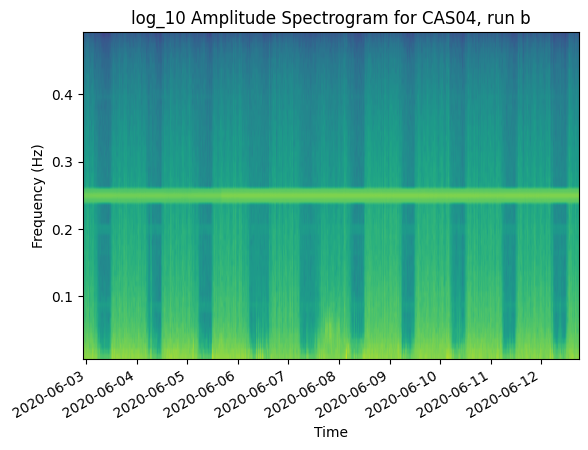

In [43]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import datetime as dt

x_lims = [ex.time.data[0], ex.time.data[-1]]

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

# Set y-limits.
y_lims = [ex.frequency.data[0], ex.frequency.data[-1]]

fig, ax = plt.subplots()

# Using ax.imshow we set two keyword arguments. The first is extent.
# We give extent the values from x_lims and y_lims above.
# We also set the aspect to "auto" which should set the plot up nicely.
ax.imshow(np.log10(ex.T), extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto', origin='lower' )

# # We tell Matplotlib that the x-axis is filled with datetime data, 
# # this converts it from a float (which is the output of date2num) 
# # into a nice datetime string.
ax.xaxis_date()

# # We can use a DateFormatter to choose how this datetime string will look.
# # I have chosen HH:MM:SS though you could add DD/MM/YY if you had data
# # over different days.
date_format = mdates.DateFormatter('%Y-%m-%d')# %H:%M:%S')

ax.xaxis.set_major_formatter(date_format)

# # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title(f"log_{10} Amplitude Spectrogram for {station_id}, run {run_id}")
plt.show()

# Absolute Minimal Example

- This is the code from Figure 3 in the JOSS manuscript intended to show that the processing can be run in 8 lines including saving results to `edi` file format.

In [44]:
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.processing import KernelDataset, RunSummary

In [45]:
run_summary = RunSummary()
run_summary.from_mth5s(["8P_CAS04_NVR08.h5",])
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04", "NVR08")
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf = process_mth5(config, kernel_dataset)
tf.write(fn="CAS04_rrNVR08.edi", file_type="edi")

2025-11-17T18:54:11.068886+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:11.074499+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.


2025-11-17T18:54:11.075187+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.


2025-11-17T18:54:11.075855+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:54:11.077043+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:54:11.077630+0000 | INFO | mth5.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


2025-11-17T18:54:11.091220+0000 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


2025-11-17T18:54:11.116035+0000 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | Window is longer than the time series -- no complete windows can be returned


2025-11-17T18:54:11.125020+0000 | ERROR | aurora.time_series.window_helpers | available_number_of_windows_in_array | Window is longer than the time series -- no complete windows can be returned


2025-11-17T18:54:11.136331+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:


2025-11-17T18:54:11.144946+0000 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
    duration  has_data  n_samples run station       survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0     2860.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128       2860.0              29.0
1     2860.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128        715.0               7.0
2     2860.0      True     847649   b   CAS04  CONUS South  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         2         4.0     0

2025-11-17T18:54:11.146225+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total memory: 15.62 GB


2025-11-17T18:54:11.146935+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Total Bytes of Raw Data: 0.027 GB


2025-11-17T18:54:11.147293+0000 | INFO | aurora.pipelines.transfer_function_kernel | memory_check | Raw Data will use: 0.171 % of memory


2025-11-17T18:54:11.150237+0000 | WARNING | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | Not all runs will process as a continuous chunk -- in future may need to loop over runlets to check for FCs


2025-11-17T18:54:11.157982+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | FCs detected -- checking against processing requirements.


2025-11-17T18:54:11.173891+0000 | INFO | mt_metadata.base.metadata | __eq__ | type: hamming != boxcar


2025-11-17T18:54:11.174420+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | window does not agree:  FC Group: window:
	clock_zero_type = ignore
	normalized = True
	num_samples = 128
	overlap = 32
	type = hamming  Processing Config  window:
	clock_zero_type = ignore
	normalized = True
	num_samples = 128
	overlap = 32
	type = boxcar


2025-11-17T18:54:11.189359+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.25 differs from processing config 1.0


2025-11-17T18:54:11.203966+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.0625 differs from processing config 1.0


2025-11-17T18:54:11.218716+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.015625 differs from processing config 1.0


2025-11-17T18:54:11.397377+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:11.399987+0000 | WARNING | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | Not all runs will process as a continuous chunk -- in future may need to loop over runlets to check for FCs


2025-11-17T18:54:11.408305+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | FCs detected -- checking against processing requirements.


2025-11-17T18:54:11.425120+0000 | INFO | mt_metadata.base.metadata | __eq__ | type: hamming != boxcar


2025-11-17T18:54:11.425693+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | window does not agree:  FC Group: window:
	clock_zero_type = ignore
	normalized = True
	num_samples = 128
	overlap = 32
	type = hamming  Processing Config  window:
	clock_zero_type = ignore
	normalized = True
	num_samples = 128
	overlap = 32
	type = boxcar


2025-11-17T18:54:11.441158+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.25 differs from processing config 1.0


2025-11-17T18:54:11.455965+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.0625 differs from processing config 1.0


2025-11-17T18:54:11.471019+0000 | INFO | mt_metadata.transfer_functions.processing.aurora.decimation_level | is_consistent_with_archived_fc_parameters | Sample rates do not agree: fc 0.015625 differs from processing config 1.0


2025-11-17T18:54:11.648228+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:11.657454+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: NVR08, run: a-- Fourier coefficients will be computed


2025-11-17T18:54:11.833979+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:11.836763+0000 | WARNING | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | Not all runs will process as a continuous chunk -- in future may need to loop over runlets to check for FCs


2025-11-17T18:54:11.844167+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: NVR08, run: b-- Fourier coefficients will be computed


2025-11-17T18:54:12.021787+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:12.030882+0000 | INFO | aurora.pipelines.transfer_function_kernel | mth5_has_fcs | Fourier coefficients not detected for survey: CONUS South, station: NVR08, run: c-- Fourier coefficients will be computed


2025-11-17T18:54:12.208622+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:12.210526+0000 | INFO | aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | FC levels not present


2025-11-17T18:54:12.214191+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | Processing config indicates 4 decimation levels


2025-11-17T18:54:12.215412+0000 | INFO | aurora.pipelines.transfer_function_kernel | valid_decimations | After validation there are 4 valid decimation levels


2025-11-17T18:54:12.493837+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-03T19:10:11+00:00 does not match metadata start 2020-06-02T22:24:55+00:00 updating metatdata value to 2020-06-03T19:10:11+00:00


2025-11-17T18:54:12.494805+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-03T19:57:51+00:00 does not match metadata end 2020-06-12T17:52:23+00:00 updating metatdata value to 2020-06-03T19:57:51+00:00


2025-11-17T18:54:13.254637+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-03T20:14:13+00:00 does not match metadata start 2020-06-02T22:24:55+00:00 updating metatdata value to 2020-06-03T20:14:13+00:00


2025-11-17T18:54:13.638706+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-12T17:52:23+00:00 does not match metadata end 2020-06-14T16:56:02+00:00 updating metatdata value to 2020-06-12T17:52:23+00:00


2025-11-17T18:54:13.946984+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-14T16:56:02+00:00 does not match metadata end 2020-07-01T17:32:59+00:00 updating metatdata value to 2020-06-14T16:56:02+00:00


2025-11-17T18:54:14.240179+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-12T18:32:17+00:00 does not match metadata start 2020-06-03T20:14:13+00:00 updating metatdata value to 2020-06-12T18:32:17+00:00


2025-11-17T18:54:14.620063+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | start time of dataset 2020-06-14T18:00:44+00:00 does not match metadata start 2020-06-12T18:32:17+00:00 updating metatdata value to 2020-06-14T18:00:44+00:00


2025-11-17T18:54:14.621244+0000 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-06-24T15:55:46+00:00 does not match metadata end 2020-07-01T17:32:59+00:00 updating metatdata value to 2020-06-24T15:55:46+00:00


2025-11-17T18:54:15.038543+0000 | INFO | mth5.processing.kernel_dataset | initialize_dataframe_for_processing | Dataset dataframe initialized successfully


2025-11-17T18:54:15.039621+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 0 Successfully


2025-11-17T18:54:15.216766+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:15.418186+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:16.083652+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:16.635948+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:16.900674+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:17.194066+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:17.756681+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:18.354747+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:18.386680+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:18.394696+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:54:18.525629+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:54:18.727183+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:54:18.933208+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:54:19.190113+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:54:19.475635+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:54:19.805196+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:54:20.143477+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:54:20.561767+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:54:20.718485+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:54:20.921909+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:54:21.126983+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:54:21.382388+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:54:21.669784+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:54:21.998372+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:54:22.344361+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:54:22.762298+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 25.728968s  (0.038867Hz)


2025-11-17T18:54:22.920217+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 19.929573s  (0.050177Hz)


2025-11-17T18:54:23.125179+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 15.164131s  (0.065945Hz)


2025-11-17T18:54:23.329235+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 11.746086s  (0.085135Hz)


2025-11-17T18:54:23.584985+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 9.195791s  (0.108745Hz)


2025-11-17T18:54:23.872382+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 7.362526s  (0.135823Hz)


2025-11-17T18:54:24.204215+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 5.856115s  (0.170762Hz)


2025-11-17T18:54:24.542048+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 4.682492s  (0.213562Hz)


2025-11-17T18:54:25.119999+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1


2025-11-17T18:54:25.480232+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully


2025-11-17T18:54:25.656484+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:25.857368+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:26.129994+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:26.431737+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:26.647565+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:26.893278+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:27.179407+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:27.488557+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:27.504165+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:27.510956+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:27.570101+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:27.645298+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:27.750508+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:27.842690+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:27.954168+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:54:28.082166+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:28.159813+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:28.235005+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:28.339525+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:28.432710+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:28.544765+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:54:28.672398+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 102.915872s  (0.009717Hz)


2025-11-17T18:54:28.749837+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 85.631182s  (0.011678Hz)


2025-11-17T18:54:28.824659+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 68.881694s  (0.014518Hz)


2025-11-17T18:54:28.929747+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 54.195827s  (0.018452Hz)


2025-11-17T18:54:29.022625+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 43.003958s  (0.023254Hz)


2025-11-17T18:54:29.134532+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 33.310722s  (0.030020Hz)


2025-11-17T18:54:29.395023+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2


2025-11-17T18:54:29.528727+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully


2025-11-17T18:54:29.752044+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:29.999680+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:30.205879+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:30.439866+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:30.660768+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:30.911221+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:30.921760+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:30.928306+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:30.971746+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:31.014255+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:31.062509+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:31.122935+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:31.193891+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:54:31.273217+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:31.328179+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:31.380764+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:31.429072+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:31.489688+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:31.560289+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:54:31.640313+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 411.663489s  (0.002429Hz)


2025-11-17T18:54:31.695546+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 342.524727s  (0.002919Hz)


2025-11-17T18:54:31.748400+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 275.526776s  (0.003629Hz)


2025-11-17T18:54:31.796832+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 216.783308s  (0.004613Hz)


2025-11-17T18:54:31.857838+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 172.015831s  (0.005813Hz)


2025-11-17T18:54:31.928802+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 133.242890s  (0.007505Hz)


2025-11-17T18:54:32.140296+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3


2025-11-17T18:54:32.218220+0000 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully


2025-11-17T18:54:32.431082+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:32.666464+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:32.843507+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:33.047263+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:33.254973+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:33.490865+0000 | INFO | aurora.time_series.spectrogram_helpers | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False


2025-11-17T18:54:33.500419+0000 | WARNING | aurora.pipelines.feature_weights | extract_features | Features could not be accessed from MTH5 -- 
Calculating features on the fly (development only)


2025-11-17T18:54:33.506741+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:33.547567+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:33.588602+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:33.630829+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:33.672791+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:54:33.716847+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:33.757187+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:33.798106+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:33.840386+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:33.882703+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:54:33.926782+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1514.701336s  (0.000660Hz)


2025-11-17T18:54:33.966888+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 1042.488956s  (0.000959Hz)


2025-11-17T18:54:34.007925+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 723.371271s  (0.001382Hz)


2025-11-17T18:54:34.050226+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 532.971560s  (0.001876Hz)


2025-11-17T18:54:34.092160+0000 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Accessing band 412.837995s  (0.002422Hz)


2025-11-17T18:54:34.290295+0000 | INFO | aurora.pipelines.process_mth5 | process_mth5_legacy | type(tf_cls): <class 'mt_metadata.transfer_functions.core.TF'>


2025-11-17T18:54:34.470121+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


2025-11-17T18:54:34.647930+0000 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


Station: 0
--------------------------------------------------
	Survey:        0
	Project:       None
	Acquired by:   None
	Acquired date: 1980-01-01
	Latitude:      0.000
	Longitude:     0.000
	Elevation:     0.000
	Impedance:     True
	Tipper:        True
	Number of periods: 25
		Period Range:   4.68249E+00 -- 1.51470E+03 s
		Frequency Range 6.60196E-04 -- 2.13561E-01 s